In [0]:
import numpy as np
import os
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,LearningRateScheduler,History
import h5py
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Reading the train and validation set from drive

f                   = h5py.File('/content/drive/My Drive/img_train_contrast_gray.h5','r')
dataset                   = f['data']
labelset                   = f['label']
dataset=np.array(dataset)
labelset=np.array(labelset)
f.close()

trDat=dataset.reshape(-1,256,256,1)
trLbl=labelset

f                   = h5py.File('/content/drive/My Drive/img_val_gray.h5','r')
dataset                   = f['data']
labelset                   = f['label']
tsDat=np.array(dataset).reshape(-1,256,256,1)
tsLbl=np.array(labelset)
f.close()

In [0]:
# normalizing data
trDat       = trDat.astype('float32')/255
tsDat       = tsDat.astype('float32')/255
trLbl=to_categorical(trLbl)
tsLbl=to_categorical(tsLbl)

In [0]:
optmz       = optimizers.RMSprop(lr=0.001)

In [0]:
def reslyr(inputs,numFilters=16,kernelSize=3,strides=1,activation='relu',batchNorm=True,convFirst=True,lyrName=None):
    convLyr=Conv2D(numFilters,kernelSize,strides=strides,padding='same',kernel_initializer='he_normal',kernel_regularizer='l2',name=lyrName+'_conv' if lyrName else None)
    if convFirst:
        x=convLyr(inputs)
        if batchNorm:
            x=BatchNormalization(name=lyrName+"_bn" if lyrName else None)(x)
        if activation is not None:
            x=Activation(activation,name=lyrName+"_activation" if lyrName else None)(x)
    else:
        if batchNorm:
            x=BatchNormalization(name=lyrName+"_bn" if lyrName else None)(x)
        if activation is not None:
            x=Activation(activation,name=lyrName+"_activation" if lyrName else None)(x)
        x=convLyr(x)
    return x 

In [0]:
def resblkv1(inputs,num_filters=16,downsample_on_first=True,num_blocks=3):
  x=inputs
  for run in range(0,num_blocks):
    strides=1
    if(downsample_on_first and run==0):
      strides=2
    y=reslyr(inputs=x,strides=strides,numFilters=num_filters)
    y=reslyr(inputs=y,activation=None,numFilters=num_filters)
    if(downsample_on_first and run==0):
      x=reslyr(inputs=x,strides=strides,batchNorm=False,activation=None,numFilters=num_filters)
    print(x.shape,y.shape)
    x=add([x,y])
    x=Activation('relu')(x)
  return x  

In [0]:
def createResnetV1(input_shape=(trDat.shape[1],trDat.shape[2],trDat.shape[3]),num_classes=3):
  inputs=Input(shape=input_shape)
  v=reslyr(inputs,numFilters=16)
  v=resblkv1(v,downsample_on_first=False,num_filters=16,num_blocks=3)
  v=resblkv1(v,downsample_on_first=True,num_filters=32,num_blocks=3)
  v=resblkv1(v,downsample_on_first=True,num_filters=64,num_blocks=3)
  v=resblkv1(v,downsample_on_first=True,num_filters=128,num_blocks=3)
  v=resblkv1(v,downsample_on_first=True,num_filters=256,num_blocks=3)
#   v=resblkv1(v,downsample_on_first=True,num_filters=512,num_blocks=3)
  v=AveragePooling2D(pool_size=8)(v)
  v=Flatten()(v)   
  outputs=Dense(3,activation='softmax',kernel_initializer='he_normal')(v)
  model=Model(inputs=inputs,outputs=outputs)
  model.compile(loss='categorical_crossentropy',optimizer=optmz,metrics=['accuracy'])
  return model

In [9]:
# create residual model
model=createResnetV1()

# commented simple CNN model with dropout
# model=Sequential()
# model.add(Input(shape=(trDat.shape[1],trDat.shape[2],trDat.shape[3])))
# model.add(Conv2D(16,kernel_size=3,padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv2D(32,kernel_size=3,padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv2D(64,kernel_size=3,padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv2D(128,kernel_size=3,padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv2D(256,kernel_size=3,padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(AveragePooling2D(pool_size=8))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(3,activation='softmax',kernel_initializer='he_normal'))
# model.compile(loss='categorical_crossentropy',optimizer=optmz,metrics=['accuracy'])

model.summary()
# learning rate scheduler
# plot_model(model, to_file='/content/drive/My Drive/model_plot_Resnet256.png', show_shapes=True, show_layer_names=True)
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr = 1e-4
    if epoch > 20:
        lr = 1e-5
    if epoch > 30:
        lr = 1e-6
    if epoch > 40:
        lr = 1e-7
    print('Learning rate: ', lr)
    return lr

(?, 256, 256, 16) (?, 256, 256, 16)
(?, 256, 256, 16) (?, 256, 256, 16)
(?, 256, 256, 16) (?, 256, 256, 16)
(?, 128, 128, 32) (?, 128, 128, 32)
(?, 128, 128, 32) (?, 128, 128, 32)
(?, 128, 128, 32) (?, 128, 128, 32)
(?, 64, 64, 64) (?, 64, 64, 64)
(?, 64, 64, 64) (?, 64, 64, 64)
(?, 64, 64, 64) (?, 64, 64, 64)
(?, 32, 32, 128) (?, 32, 32, 128)
(?, 32, 32, 128) (?, 32, 32, 128)
(?, 32, 32, 128) (?, 32, 32, 128)
(?, 16, 16, 256) (?, 16, 16, 256)
(?, 16, 16, 256) (?, 16, 16, 256)
(?, 16, 16, 256) (?, 16, 16, 256)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[

In [0]:
# image data runtime augmentor(not used , as it makes training extremely slow)
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=True,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
  

In [21]:
# checkpoint to save model with best validation accuracy
checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/img_model_gray_contrast_Residua256.h5',
                             monitor='val_acc',
                             verbose=1,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
lr_scheduler = LearningRateScheduler(lr_schedule)
model.load_weights('/content/drive/My Drive/img_model_gray_contrast_Residua256.h5')
history=model.fit(trDat,trLbl,validation_data=(tsDat,tsLbl),epochs=50,batch_size=32,shuffle=True,callbacks=[checkpoint,lr_reducer,lr_scheduler])
# datagen.fit(trDat)

# Fit the model on the batches generated by datagen.flow().
# model.fit_generator(datagen.flow(trDat,trLbl, batch_size=1),
#                         validation_data=(tsDat,tsLbl),
#                         epochs=100, verbose=1, workers=1,
#                         callbacks=[checkpoint,lr_reducer,lr_scheduler])

Train on 4108 samples, validate on 103 samples
Learning rate:  0.001
Epoch 1/50
4096/4108 [============================>.] - ETA: 0s - loss: 0.9891 - acc: 0.6516
Epoch 00001: val_acc improved from -inf to 0.28155, saving model to /content/drive/My Drive/img_model_gray_contrast_Residua256.h5
4108/4108 [==============================] - 165s 40ms/sample - loss: 0.9892 - acc: 0.6514 - val_loss: 32.5065 - val_acc: 0.2816
Learning rate:  0.001
Epoch 2/50
4096/4108 [============================>.] - ETA: 0s - loss: 0.9032 - acc: 0.6675
Epoch 00002: val_acc improved from 0.28155 to 0.64078, saving model to /content/drive/My Drive/img_model_gray_contrast_Residua256.h5
4108/4108 [==============================] - 143s 35ms/sample - loss: 0.9035 - acc: 0.6670 - val_loss: 1.0468 - val_acc: 0.6408
Learning rate:  0.001
Epoch 3/50
4096/4108 [============================>.] - ETA: 0s - loss: 0.9193 - acc: 0.6726
Epoch 00003: val_acc did not improve from 0.64078
4108/4108 [===========================

KeyboardInterrupt: ignored

In [10]:
# Analyse failed predictions
model.load_weights('/content/drive/My Drive/img_model_gray_contrast_Residua256.h5')
for i in range(tsDat.shape[0]):
  val=tsDat[i]
  pred=model.predict(val.reshape(1,256,256,1),verbose=0)
  print(i,pred,tsLbl[i])

0 [[0.5372224  0.06349102 0.39928666]] [1. 0. 0.]
1 [[0.5194152  0.22362989 0.2569549 ]] [1. 0. 0.]
2 [[0.50075424 0.2619148  0.23733096]] [1. 0. 0.]
3 [[0.932822   0.04117062 0.02600738]] [1. 0. 0.]
4 [[0.73078823 0.21315819 0.05605352]] [1. 0. 0.]
5 [[0.38013318 0.28732124 0.33254555]] [1. 0. 0.]
6 [[0.04367867 0.00918837 0.94713295]] [1. 0. 0.]
7 [[0.37440014 0.25927567 0.3663242 ]] [1. 0. 0.]
8 [[0.8937113  0.00842195 0.09786662]] [1. 0. 0.]
9 [[0.5935804  0.00880952 0.39761   ]] [1. 0. 0.]
10 [[0.93210554 0.02897062 0.03892381]] [1. 0. 0.]
11 [[0.9579021  0.01779595 0.02430202]] [1. 0. 0.]
12 [[0.94768906 0.01533524 0.0369757 ]] [1. 0. 0.]
13 [[0.09207196 0.00438494 0.9035431 ]] [1. 0. 0.]
14 [[0.31762373 0.00447993 0.6778963 ]] [1. 0. 0.]
15 [[0.9885006  0.00329088 0.00820856]] [1. 0. 0.]
16 [[0.03683266 0.46025887 0.50290847]] [1. 0. 0.]
17 [[0.9554876  0.03037775 0.01413473]] [1. 0. 0.]
18 [[0.86435086 0.08487381 0.05077535]] [1. 0. 0.]
19 [[0.9852881  0.00398917 0.01072279]] [

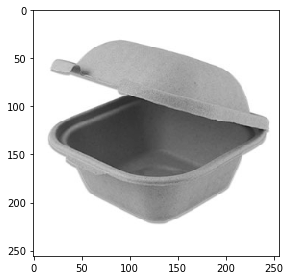

In [11]:
# visualizing failed images
import random
from skimage.io import imshow
imshow(tsDat[13].reshape(256,256));

In [0]:
# Trying an autoencoder model
def AEModel(input_img):
    conv1 = Conv2D(1, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 

#     conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) 
#     up1 = UpSampling2D((2,2))(conv4) 
#     conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(pool1) 
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

In [106]:
input_img = Input(shape = (256, 256, 1))
autoencoder=Model(input_img,AEModel(input_img))
# autoencoder=build_AE_machine(trDat)
autoencoder.summary()
autoencoder.compile(loss='mse', optimizer =optmz)
autoencoder.fit(trDat[trLbl[:,0]==1,:,:,:], trDat[trLbl[:,0]==1,:,:,:], batch_size=128,epochs=20,verbose=1)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 256, 256, 1)       10        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 128, 128, 1)       0         
_________________________________________________________________
up_sampling2d_28 (UpSampling (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 256, 256, 1)       10        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1351/1351 [==============================] - 2s 2ms/sample - loss: 0.2795
Epoch 2/20
1351/1351 [=====================

In [0]:
def show_encodings(inputs,outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n)
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(256, 256), cmap='gray')
        axes[1, i].imshow((outputs[i]).reshape(256, 256), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

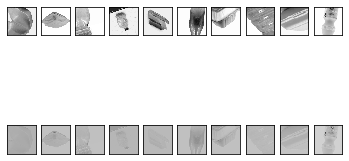

In [107]:
import matplotlib.pyplot as plt
num_sample = 5 # Number of test samples used for visualization
# data_encode = model_encoder.predict(tsDat[:num_sample])

data_rec = autoencoder.predict(trDat[trLbl[:,0]==1,:,:,:][0:10])
# data_rec_val=model.predict(tsDat.reshape(tsDat.shape[0],-1))
show_encodings(trDat[trLbl[:,0]==1,:,:,:][0:10], data_rec)

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [116]:
input_img = Input(shape = (256, 256, 1))
autoencoder2=Model(input_img,AEModel(input_img))
# autoencoder2.summary()
autoencoder2.compile(loss='mse', optimizer =optmz)
autoencoder2.fit(trDat[trLbl[:,1]==1,:,:,:], trDat[trLbl[:,1]==1,:,:,:], batch_size=128,epochs=30,verbose=1)

Epoch 1/30
1413/1413 [==============================] - 3s 2ms/sample - loss: 0.1595
Epoch 2/30
1413/1413 [==============================] - 1s 1ms/sample - loss: 0.1398
Epoch 3/30
1413/1413 [==============================] - 1s 993us/sample - loss: 0.1293
Epoch 4/30
1413/1413 [==============================] - 1s 1ms/sample - loss: 0.1212
Epoch 5/30
1413/1413 [==============================] - 1s 1ms/sample - loss: 0.1156
Epoch 6/30
1413/1413 [==============================] - 1s 1ms/sample - loss: 0.1119
Epoch 7/30
1413/1413 [==============================] - 1s 994us/sample - loss: 0.1099
Epoch 8/30
1413/1413 [==============================] - 1s 1ms/sample - loss: 0.1088
Epoch 9/30
1413/1413 [==============================] - 1s 986us/sample - loss: 0.1079
Epoch 10/30
1413/1413 [==============================] - 1s 993us/sample - loss: 0.1068
Epoch 11/30
1413/1413 [==============================] - 1s 984us/sample - loss: 0.1058
Epoch 12/30
1413/1413 [==============================

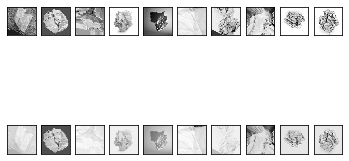

In [117]:
import matplotlib.pyplot as plt
num_sample = 5 # Number of test samples used for visualization
# data_encode = model_encoder.predict(tsDat[:num_sample])

data_rec = autoencoder2.predict(trDat[trLbl[:,1]==1,:,:,:][0:10])
# data_rec_val=model.predict(tsDat.reshape(tsDat.shape[0],-1))
show_encodings(trDat[trLbl[:,1]==1,:,:,:][0:10], data_rec)

In [111]:
input_img = Input(shape = (256, 256, 1))
autoencoder3=Model(input_img,AEModel(input_img))
# autoencoder2.summary()
autoencoder3.compile(loss='mse', optimizer =optmz)
autoencoder3.fit(trDat[trLbl[:,2]==1,:,:,:], trDat[trLbl[:,2]==1,:,:,:], batch_size=128,epochs=20,verbose=1)

Epoch 1/20
1344/1344 [==============================] - 3s 2ms/sample - loss: 0.0424
Epoch 2/20
1344/1344 [==============================] - 1s 998us/sample - loss: 0.0398
Epoch 3/20
1344/1344 [==============================] - 1s 1000us/sample - loss: 0.0386
Epoch 4/20
1344/1344 [==============================] - 1s 994us/sample - loss: 0.0376
Epoch 5/20
1344/1344 [==============================] - 1s 1ms/sample - loss: 0.0366
Epoch 6/20
1344/1344 [==============================] - 1s 999us/sample - loss: 0.0356
Epoch 7/20
1344/1344 [==============================] - 1s 989us/sample - loss: 0.0347
Epoch 8/20
1344/1344 [==============================] - 1s 1ms/sample - loss: 0.0336
Epoch 9/20
1344/1344 [==============================] - 1s 998us/sample - loss: 0.0326
Epoch 10/20
1344/1344 [==============================] - 1s 992us/sample - loss: 0.0316
Epoch 11/20
1344/1344 [==============================] - 1s 1ms/sample - loss: 0.0306
Epoch 12/20
1344/1344 [=========================

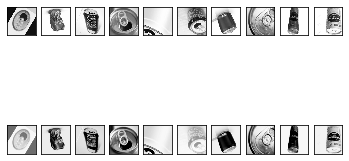

In [112]:
import matplotlib.pyplot as plt
num_sample = 5 # Number of test samples used for visualization
# data_encode = model_encoder.predict(tsDat[:num_sample])

data_rec = autoencoder3.predict(trDat[trLbl[:,2]==1,:,:,:][0:10])
# data_rec_val=model.predict(tsDat.reshape(tsDat.shape[0],-1))
show_encodings(trDat[trLbl[:,2]==1,:,:,:][0:10], data_rec)

In [0]:
# pred=[]
# for i in range(tsDat.shape[0]):
  test_data_predict1=autoencoder.predict(tsDat)
  test_data_predict2=autoencoder2.predict(tsDat)
  test_data_predict3=autoencoder3.predict(tsDat)
#   pred.append(np.argmin(np.linalg.norm(tsDat[i] - test_data_predict1, axis=-1),
#             np.linalg.norm(tsDat[i] - test_data_predict2, axis=-1),
#             np.linalg.norm(tsDat[i] - test_data_predict3, axis=-1)))

In [0]:
pred=[]
for i in range(tsDat.shape[0]):
  pred.append(np.argmin([np.linalg.norm(tsDat[i] - test_data_predict1[i]),
            np.linalg.norm(tsDat[i] - test_data_predict2[i]),
            np.linalg.norm(tsDat[i] - test_data_predict3[i])]))

In [0]:
orig=[]
for i in range(tsDat.shape[0]):
  orig.append(np.argmax(tsLbl[i]))

In [120]:
from sklearn.metrics import accuracy_score
accuracy_score(pred,orig)

0.5242718446601942